In [1]:
import pandas as pd

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
def sort_d1d2(df):
    d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
    df.drop(['d1', 'd2'], 1)
    df['d1'] = d1s
    df['d2'] = d2s
    return df

In [4]:
dfc = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ob.json/'))))
dfc = sort_d1d2(dfc)

955500it [00:02, 381793.00it/s]


In [5]:
dfa = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/window-actor-corrs.json/'))))
dfa = sort_d1d2(dfa)

9555it [00:00, 215756.61it/s]


In [6]:
dfc_mean = dfc.groupby(['d1', 'd2', 'window']).mean().reset_index()

In [64]:
# dfc_mean['score'] = preprocessing.scale(-dfc_mean.acc)
# dfa['score'] = preprocessing.scale(dfa['corr'])

dfc_mean['score'] = dfc_mean.groupby('window').acc.transform(lambda x: preprocessing.scale(-x))
dfa['score'] = dfa.groupby('window')['corr'].transform(preprocessing.scale)

In [65]:
pairs = set(map(tuple, dfc[['d1', 'd2']].values.tolist()))

In [66]:
rows = []
for d1, d2 in pairs:
    
    pdfc = dfc_mean[(dfc_mean.d1==d1)&(dfc_mean.d2==d2)].sort_values('window')
    pdfa = dfa[(dfa.d1==d1)&(dfa.d2==d2)].sort_values('window')
    
#     corr, p = stats.kendalltau(-pdfc.acc, pdfa['corr'])
    corr, p = stats.pearsonr(pdfc.score, pdfa.score)
    rows.append((d1, d2, corr, p))

In [67]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))
corr_df['label'] = corr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [68]:
corr_df.mean()['corr']

0.023327470754116827

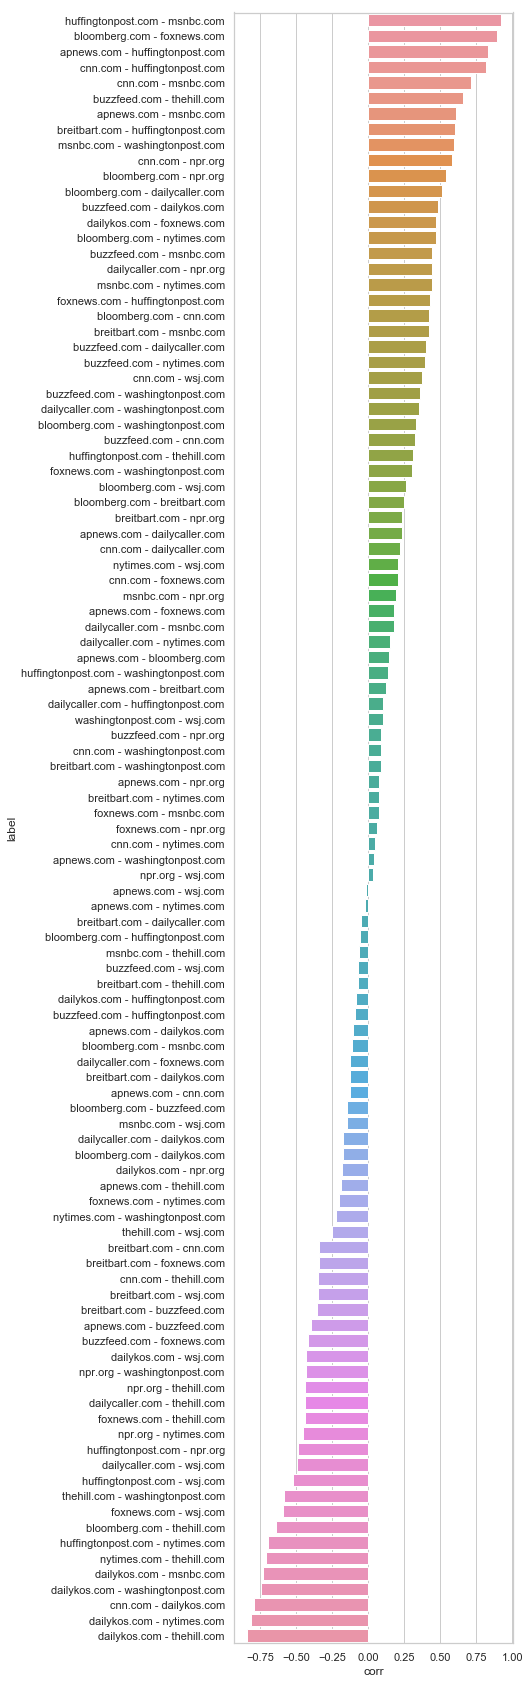

In [69]:
plt.figure(figsize=(5,30))
sns.barplot(x='corr', y='label', data=corr_df.sort_values('corr', ascending=False))

In [70]:
def plot_pair(d1, d2):
    
    pdfc = dfc_mean[(dfc_mean.d1==d1)&(dfc_mean.d2==d2)].sort_values('window').copy()
#     pdfc['score'] = -preprocessing.scale(pdfc.acc)
    
    pdfa = dfa[(dfa.d1==d1)&(dfa.d2==d2)].sort_values('window')
#     pdfa['score'] = preprocessing.scale(pdfa['corr'])
    
    plt.figure(figsize=(5,3))
#     plt.ylim(-3, 4)
    sns.lineplot(x='window', y='score', data=pdfc, label='content')
    sns.lineplot(x='window', y='score', data=pdfa, label='audience')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

huffingtonpost.com msnbc.com


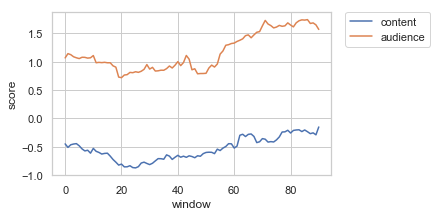

bloomberg.com foxnews.com


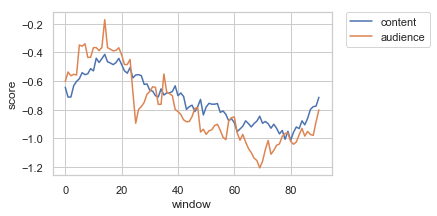

apnews.com huffingtonpost.com


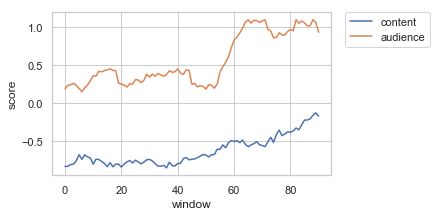

cnn.com huffingtonpost.com


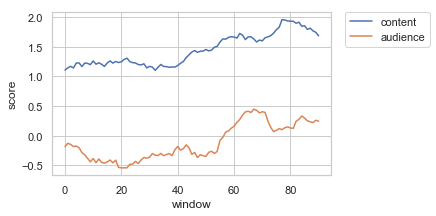

cnn.com msnbc.com


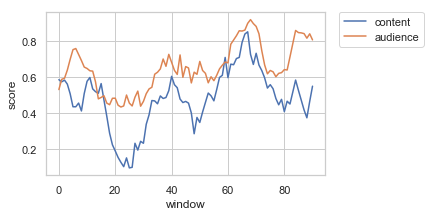

buzzfeed.com thehill.com


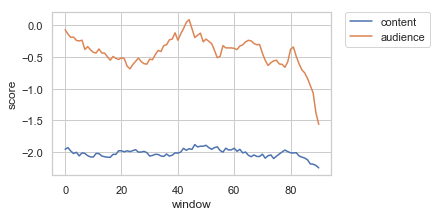

apnews.com msnbc.com


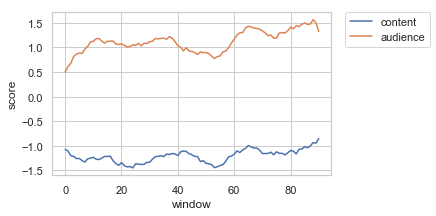

breitbart.com huffingtonpost.com


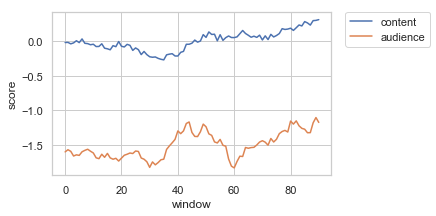

msnbc.com washingtonpost.com


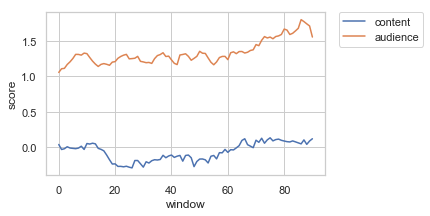

cnn.com npr.org


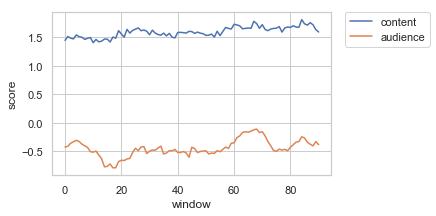

In [71]:
for r in corr_df.sort_values('corr', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

dailykos.com thehill.com


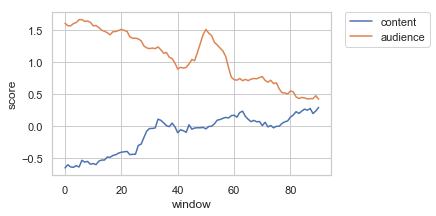

dailykos.com nytimes.com


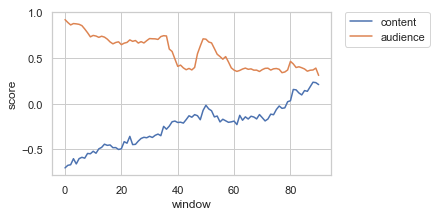

cnn.com dailykos.com


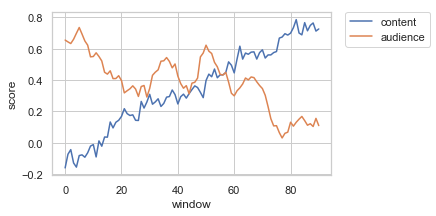

dailykos.com washingtonpost.com


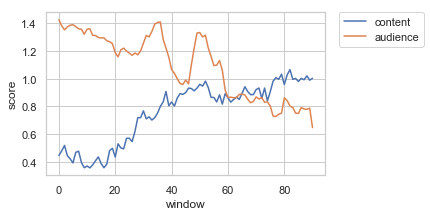

dailykos.com msnbc.com


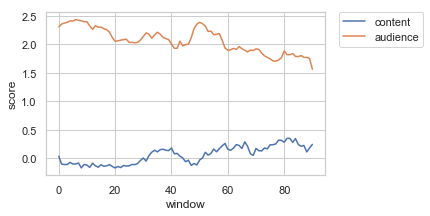

nytimes.com thehill.com


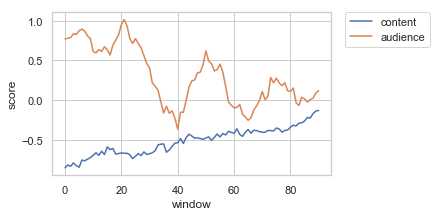

huffingtonpost.com nytimes.com


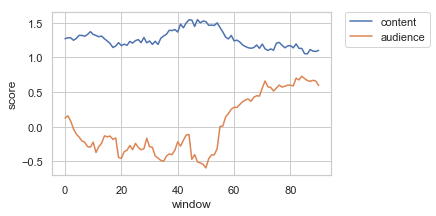

bloomberg.com thehill.com


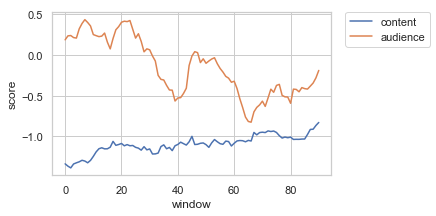

foxnews.com wsj.com


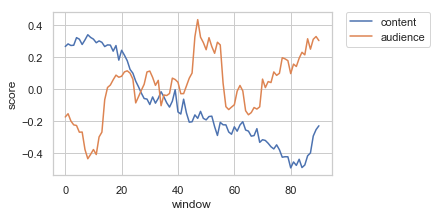

thehill.com washingtonpost.com


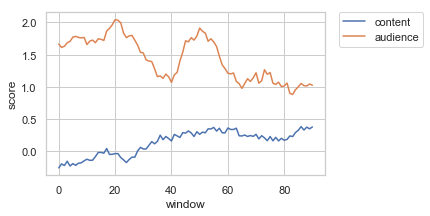

In [72]:
for r in corr_df.sort_values('corr', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)